In [34]:
# Import statements
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

In [16]:
import statsmodels.api as sm

In [3]:
qol = pd.read_excel('Downloads/Quality of Life - Data set.xls') # requires xlrd

# format QoL dataframe

In [4]:
qol.columns = [i.rstrip(' \t') for i in qol.columns]
qol = qol.replace(' ', np.nan)

In [5]:
qol = qol.dropna(how='all', axis=1) # this is more of a formatting issue. many rows with now values (excel issue)
qol = qol.dropna(how='any', axis=0) # drop individual with missing value in Insommnia score at timepoint 2

# quick look at the GLOBAL variable

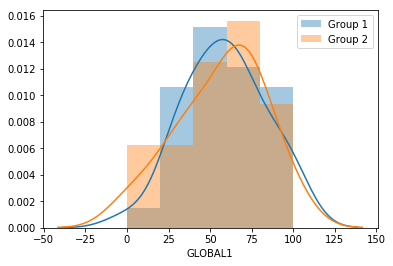

In [7]:
# before
sns.distplot(qol.loc[qol['GROUP']==1]['GLOBAL1'], label="Group 1")
sns.distplot(qol.loc[qol['GROUP']==2]['GLOBAL1'], label="Group 2")
plt.legend()
plt.show()

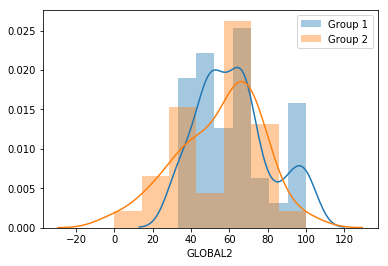

In [117]:
# after
sns.distplot(qol.loc[qol['GROUP']==1]['GLOBAL2'], label="Group 1")
sns.distplot(qol.loc[qol['GROUP']==2]['GLOBAL2'], label="Group 2")
plt.legend()
plt.show()

### check for normality
 ( in order to figure out what kind of test to use ) 

In [119]:

def make_qq(dataframe, item='GLOBAL', g1=1, g2=2, axis=None, cohens=True):
    #Define Groups
    group1 = dataframe.loc[dataframe['GROUP']==g1]
    group2 = dataframe.loc[dataframe['GROUP']==g2]
    
    # Get values at time point 1 & 2 for G1
    g1_t1 = group1[item+'1']
    g1_t2 = group1[item+'2']
    # get difference
    g1_tdiff = g1_t2 - g1_t1

    # Get values at time point 1 & 2 for G2
    g2_t1 = group2[item+'1']
    g2_t2 = group2[item+'2']
    # get difference
    g2_tdiff = g2_t2 - g2_t1
    
    fig, (ax, ax1) = plt.subplots(ncols=2, nrows=1)
    
    sm.graphics.qqplot(g1_tdiff, ax=ax)
    sm.graphics.qqplot(g2_tdiff, ax=ax1)
    fig.suptitle(item)
    plt.tight_layout()



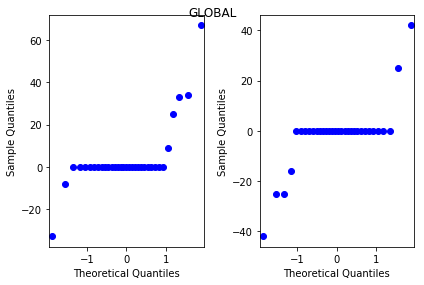

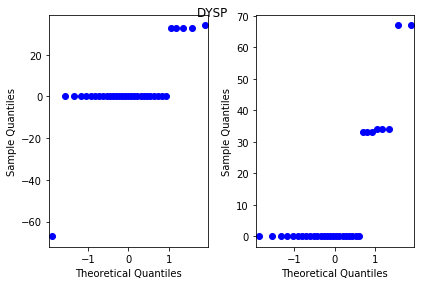

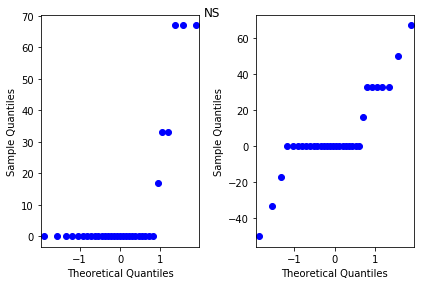

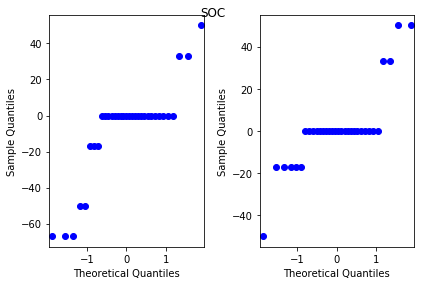

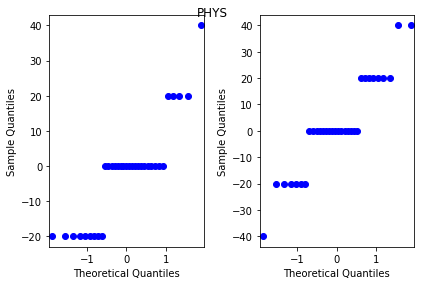

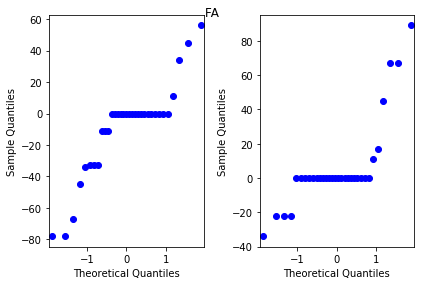

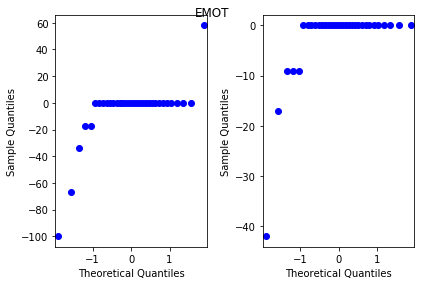

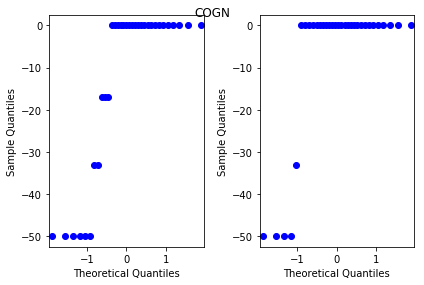

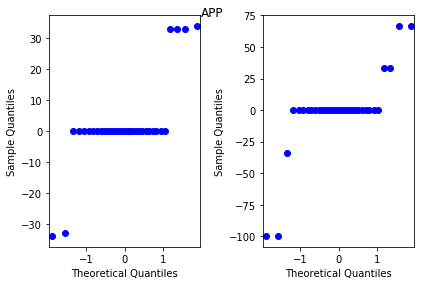

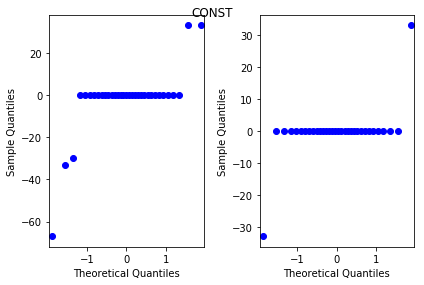

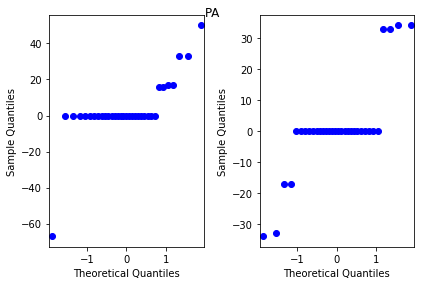

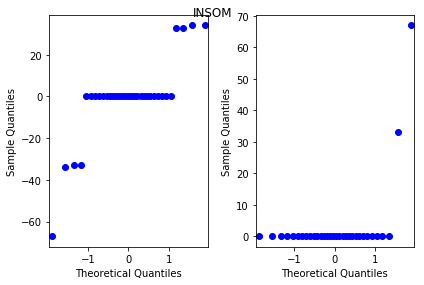

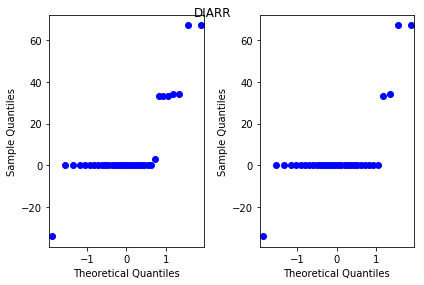

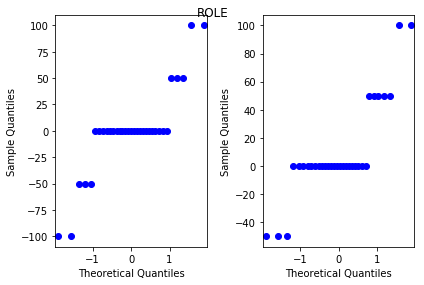

In [121]:
for i, j in enumerate(set_val):
    if not j.startswith('GROUP'):
        #print(j)
        make_qq(dataframe=qol, item=j)
    

- some of the scores do not seem to be normally distributed when comparing them to a normal distribution in a qqplot
- for consistency, we will use the same test for all scores
- therefore we will use a twosided Mann-Whitney U test.


#### function for pooled standard deviation:

## $SD_{pooled} = \sqrt{\frac{(n_{1}-1)SD^{2}_{1}+(n_{2}-1)SD^{2}_{2}}{(n_{1}+n_{2}-2)}}  $

In [13]:
def make_pooled_sd(dist1, dist2):
    #get length of the distributions
    n1 = np.float(len(dist1))         
    n2 = np.float(len(dist2))         
    #get standard deviations
    sd1 = np.float(np.std(dist1))         
    sd2 = np.float(np.std(dist2))  
    
    g1_upper = (n1-1)*(np.power(sd1,2.0))     
    g2_upper = (n2-1)*(np.power(sd2,2.0))

    upper = g1_upper+g2_upper
    down = (n1+n2-2)
    pooled_sd = np.sqrt(upper/down)
    
    return pooled_sd

#### function for cohens d : 

## $Cohen's d = \frac{\mu_1 -\mu_2}{SD_{pooled}}$

In [14]:
def make_cohens_d(dist1, dist2):
    pooled_sd = make_pooled_sd(dist1=dist1, dist2=dist2)
    cohens_d = (np.mean(dist1) - np.mean(dist2))/pooled_sd
    return cohens_d

In [108]:
def make_pvals(dataframe, item='GLOBAL', g1=1, g2=2):
    """
     - Calculate difference for all items in the dataframe betweent timepoint 1 and timepoint 2
     - perform mann-whitney U test between group 1 and group2
     - calculate rank-biserial correlation coefficient for said comparison 
    """
    #Define Groups
    group1 = dataframe.loc[dataframe['GROUP']==g1]
    group2 = dataframe.loc[dataframe['GROUP']==g2]
    
    # Get values at time point 1 & 2 for G1
    g1_t1 = group1[item+'1']
    g1_t2 = group1[item+'2']
    # get difference
    g1_tdiff = g1_t2 - g1_t1

    # Get values at time point 1 & 2 for G2
    g2_t1 = group2[item+'1']
    g2_t2 = group2[item+'2']
    # get difference
    g2_tdiff = g2_t2 - g2_t1
    
    a,r = compute_results(dist1=g2_tdiff, dist2=g1_tdiff)
    
    return a,r




In [107]:
def compute_results(dist1, dist2):
    """
     a = Calculate mann-whitney-U test,  
     r = Calculate biserial-rank-correlation, using Wendt 1972 simplified equation (https://doi.org/10.1002/ejsp.2420020412)
    """
    n1 = np.float(len(dist1))         
    n2 = np.float(len(dist2))         
    a = sc.stats.mannwhitneyu(x=dist1, y=dist2, alternative='two-sided')
    ustat = a.statistic
    r = 1 - ((2*ustat)/(n1 * n2))
    return a,r
             

In [382]:
results_dict = {}
for i, j in enumerate(set_val):
    if not j.startswith('GROUP'):
        print(j)
        a, r = make_pvals(dataframe=qol, item=j)
        results_dict[j] = {'pval':a.pvalue,
                           'r':r}

GLOBAL
MannwhitneyuResult(statistic=454.5, pvalue=0.170324475105601) 0.13920454545454541
DYSP
MannwhitneyuResult(statistic=601.5, pvalue=0.1821986714786601) -0.13920454545454541
NS
MannwhitneyuResult(statistic=517.0, pvalue=0.858350261760894) 0.02083333333333337
SOC
MannwhitneyuResult(statistic=581.5, pvalue=0.40164638917900986) -0.10132575757575757
PHYS
MannwhitneyuResult(statistic=598.0, pvalue=0.3159043557369896) -0.13257575757575757
FA
MannwhitneyuResult(statistic=658.5, pvalue=0.051395782422597173) -0.24715909090909083
EMOT
MannwhitneyuResult(statistic=520.5, pvalue=0.8881511858235527) 0.014204545454545414
COGN
MannwhitneyuResult(statistic=613.0, pvalue=0.14120349691340053) -0.1609848484848484
APP
MannwhitneyuResult(statistic=515.0, pvalue=0.8142875325289642) 0.024621212121212155
CONST
MannwhitneyuResult(statistic=543.5, pvalue=0.7144923909764691) -0.029356060606060552
PA
MannwhitneyuResult(statistic=454.0, pvalue=0.20199317974474118) 0.14015151515151514
INSOM
MannwhitneyuResult(s

In [392]:
print('feature', 'Mann-Whitney_U_test', 'correlation_coefficient_r')
for k,i in results_dict.items():
    print(k, i['pval'], i['r'])


feature Mann-Whitney_U_test correlation_coefficient_r
GLOBAL 0.170324475105601 0.13920454545454541
DYSP 0.1821986714786601 -0.13920454545454541
NS 0.858350261760894 0.02083333333333337
SOC 0.40164638917900986 -0.10132575757575757
PHYS 0.3159043557369896 -0.13257575757575757
FA 0.051395782422597173 -0.24715909090909083
EMOT 0.8881511858235527 0.014204545454545414
COGN 0.14120349691340053 -0.1609848484848484
APP 0.8142875325289642 0.024621212121212155
CONST 0.7144923909764691 -0.029356060606060552
PA 0.20199317974474118 0.14015151515151514
INSOM 0.5374965647371519 -0.05681818181818188
DIARR 0.3197080480429799 0.10416666666666663
ROLE 0.3634378255510685 -0.10795454545454541


# Plotting functions

In [114]:
def make_difference_hist(dataframe, item='GLOBAL', g1=1, g2=2, axis=None, corrcoeff=True):
    #Define Groups
    group1 = dataframe.loc[dataframe['GROUP']==g1]
    group2 = dataframe.loc[dataframe['GROUP']==g2]
    
    # Get values at time point 1 & 2 for G1
    g1_t1 = group1[item+'1']
    g1_t2 = group1[item+'2']
    # get difference
    g1_tdiff = g1_t2 - g1_t1

    # Get values at time point 1 & 2 for G2
    g2_t1 = group2[item+'1']
    g2_t2 = group2[item+'2']
    # get difference
    g2_tdiff = g2_t2 - g2_t1
    
    
    n2 = len(g2_tdiff)
    sd2 = np.std(g2_tdiff)
    
    sns.distplot(g1_tdiff, label='Group1', ax=axis, kde=False, bins=10)
    sns.distplot(g2_tdiff, label='Group2', ax=axis, kde=False, bins=10)
    
    a,r = compute_results(dist1=g2_tdiff, dist2=g1_tdiff)
    #a = sc.stats.mannwhitneyu(x=g2_tdiff, y=g1_tdiff, alternative='two-sided')
    
    axis.plot([], [], ' ', label="Mann-Whitney rank test, two-sided, p-value: {a}".format(a=np.round(a.pvalue, decimals=4)))

    if corrcoeff == True:
        axis.plot([], [], ' ', label="Wendts Rank-biserial coefficient of correlation r: {cd}".format(cd=np.round(r, decimals=3)))


### get list of all scores from the dataframe

In [31]:
set_val = list(set([i.rstrip('12') for i in qol.columns if not i.startswith('Un') ]))
set_val = [i for i in set_val if not i.startswith('GROUP')]


### example plot for one score

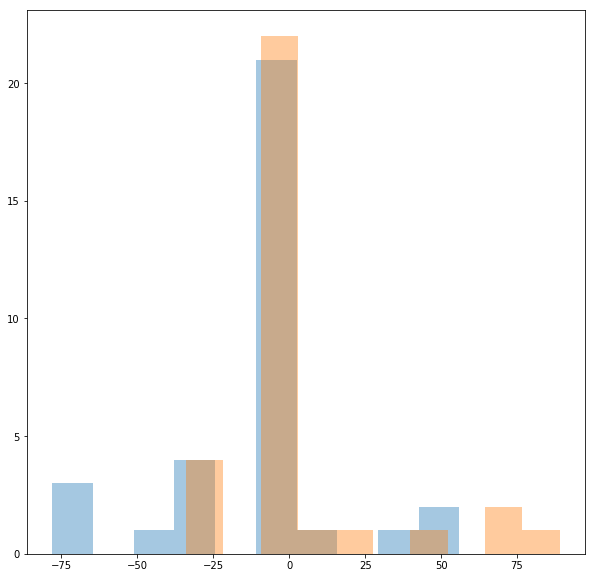

In [386]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,10))
make_difference_hist(dataframe=qol, item='FA', axis=ax, corrcoeff=True)
#plt.legend()
plt.show()

### plot all scores

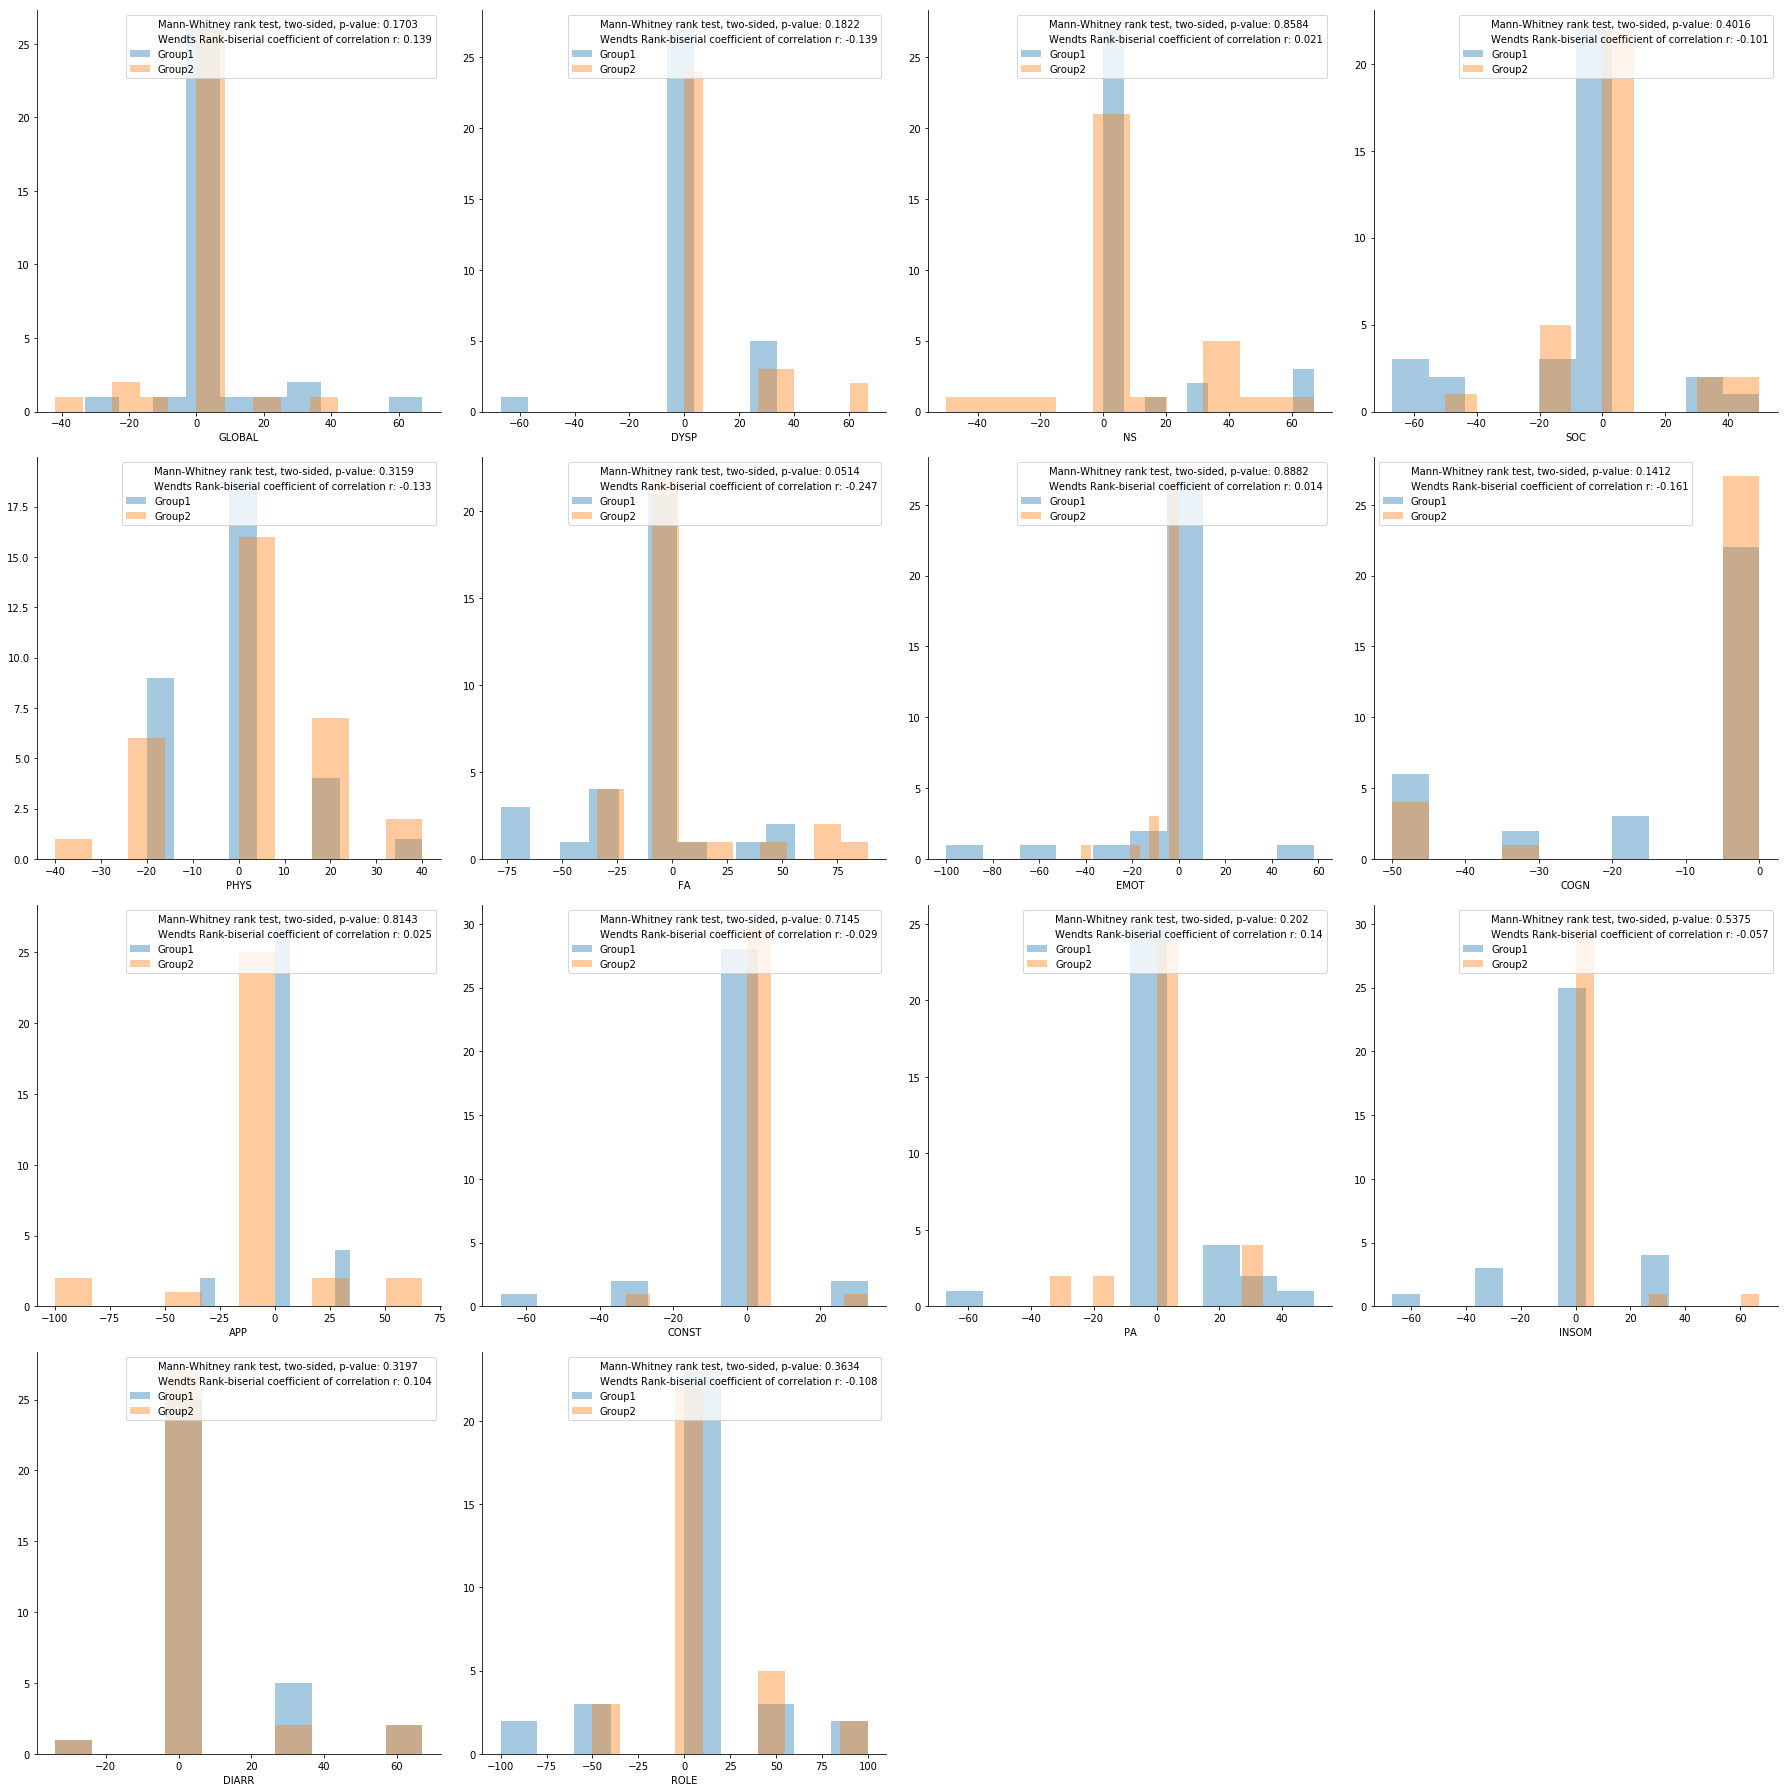

In [116]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(25,25))

for j,i in zip(set_val, ax.flatten()):
    if not j.startswith('GROUP'):
         if not j.startswith('Un'):
            #print(j)
            make_difference_hist(dataframe=qol, item=j, axis=i)
            i.set_xlabel(j)
            i.legend()
ax[3,3].axis('off')
ax[3,2].axis('off')           
sns.despine()
plt.tight_layout()   
plt.show()
    



### format data to plot an overall collection of boxplots

Answers. If you just want the entire background for both the figure and the axes to be transparent, you can simply specify transparent=True when saving the figure with fig. savefig . If you want more fine-grained control, you can simply set the facecolor and/or alpha values for the figure and axes background patch.Jun 19, 2020

In [168]:
def get_differences(dataframe, item='GLOBAL', g1=1, g2=2):
    #Define Groups
    group1 = dataframe.loc[dataframe['GROUP']==g1]
    group2 = dataframe.loc[dataframe['GROUP']==g2]
    
    # Get values at time point 1 & 2 for G1
    g1_t1 = group1[item+'1']
    g1_t2 = group1[item+'2']
    # get difference
    g1_tdiff = g1_t2 - g1_t1

    # Get values at time point 1 & 2 for G2
    g2_t1 = group2[item+'1']
    g2_t2 = group2[item+'2']
    # get difference
    g2_tdiff = g2_t2 - g2_t1
    
    a = []
    for i in g2_tdiff:
        a.append(['Control', item, i])
    for i in g1_tdiff:
        a.append(['Treatment', item, i])
    return a
    

In [169]:
diff = []
for j in set_val:
    if not j.startswith('GROUP'):
         if not j.startswith('Un'):
            a = get_differences(dataframe=qol, item=j)
            diff = diff+a
diff_df = pd.DataFrame(diff)
diff_df.columns = ['group', 'feature', 'scorechange']

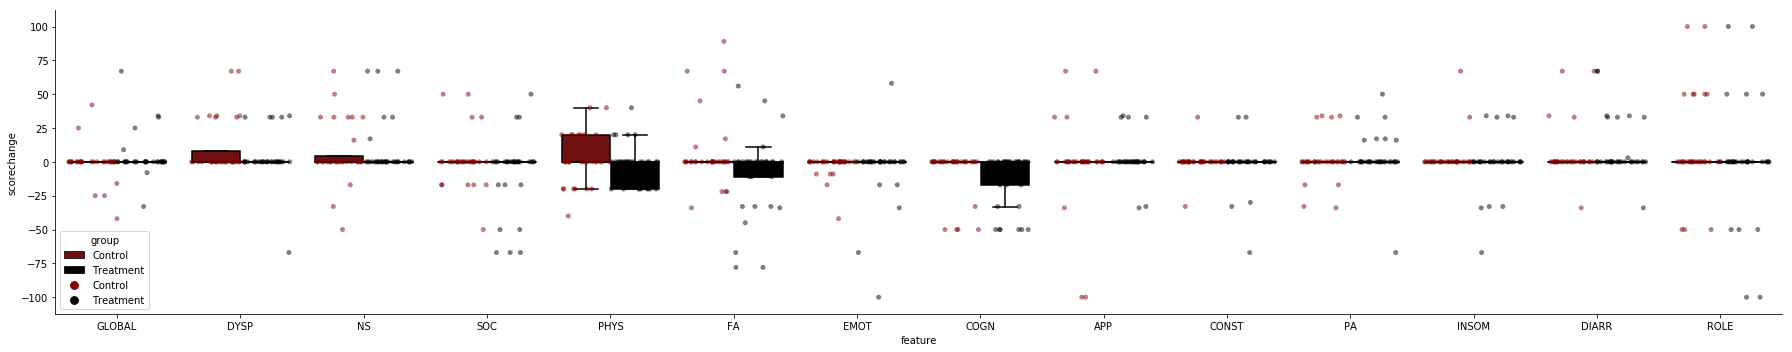

In [374]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
#sns.violinplot(data=diff_df, y='scorechange',x='feature', hue='group', ax=ax, palette=['grey', 'black'])
sns.boxplot(data=diff_df, y='scorechange',x='feature', hue='group', ax=ax, palette=['maroon', 'black'], fliersize=0)

sns.stripplot(data=diff_df, y='scorechange',x='feature', hue='group', dodge=True, ax=ax, alpha=0.5, jitter=0.4, palette=['maroon', 'black'])

#sns.boxenplot(data=diff_df, y='scorechange',x='feature', hue='group', ax=ax, palette=['grey', 'black'])


plt.tight_layout()
sns.despine()
plt.show()

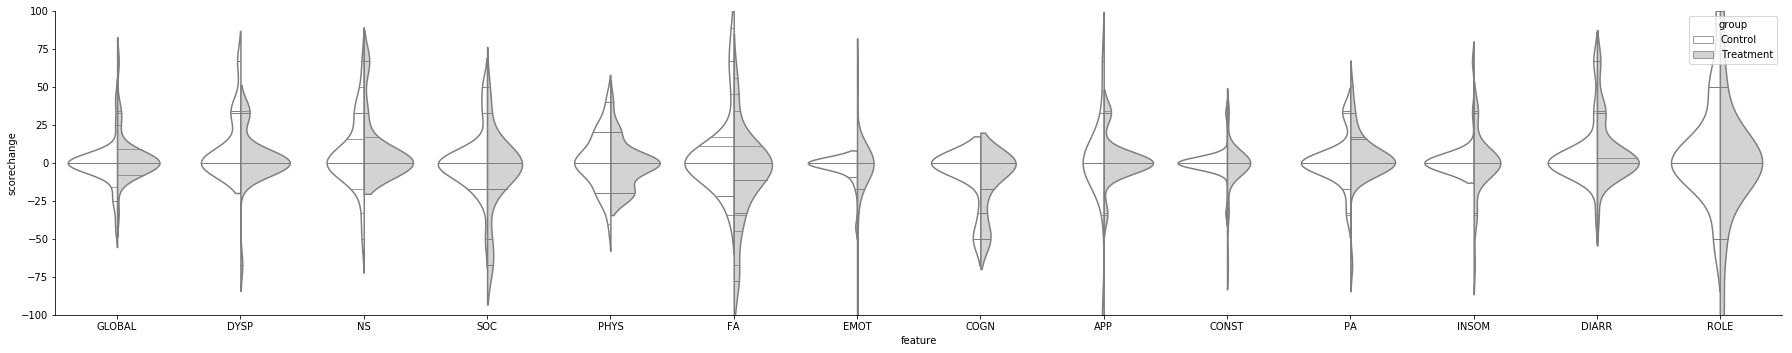

In [371]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
sns.violinplot(data=diff_df, y='scorechange',x='feature', hue='group', ax=ax, palette=['white', 'lightgrey'], inner='stick', split=True)

plt.tight_layout()
sns.despine()
ax.set_ylim(-100, 100)
plt.show()

GLOBAL
DYSP
NS
SOC
PHYS
FA
EMOT
COGN
APP
CONST
PA
INSOM
DIARR
ROLE


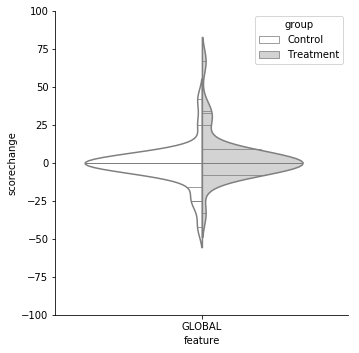

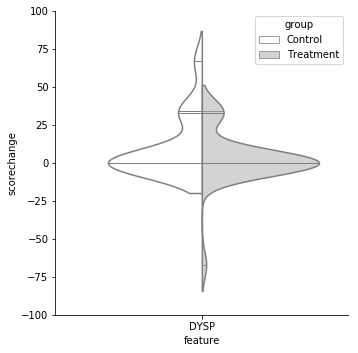

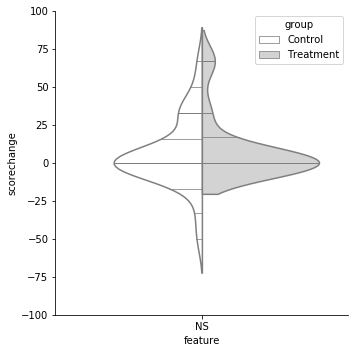

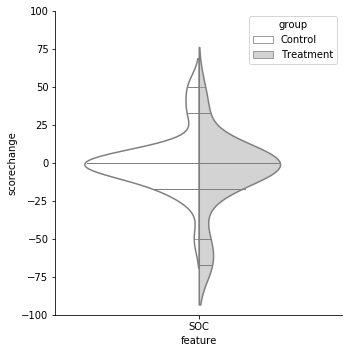

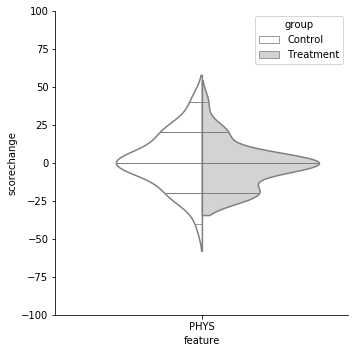

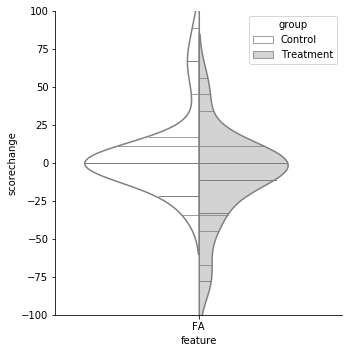

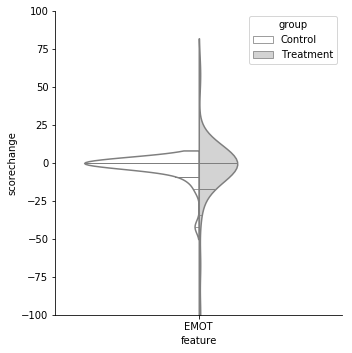

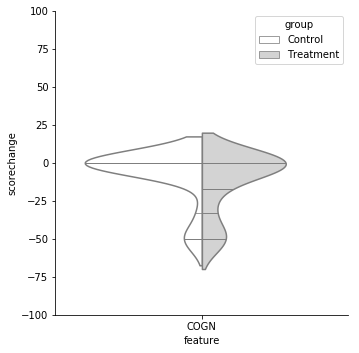

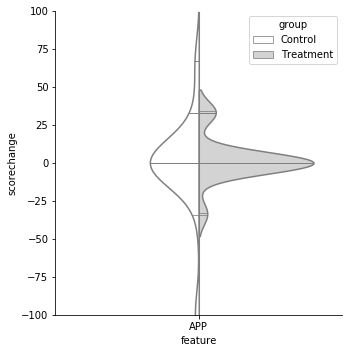

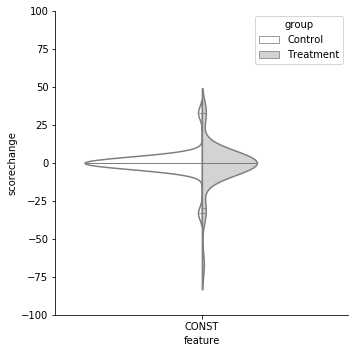

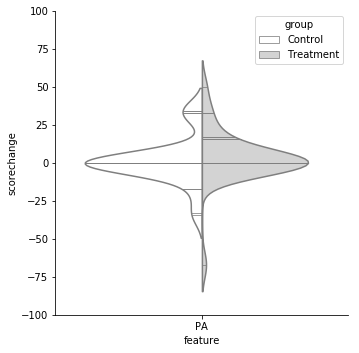

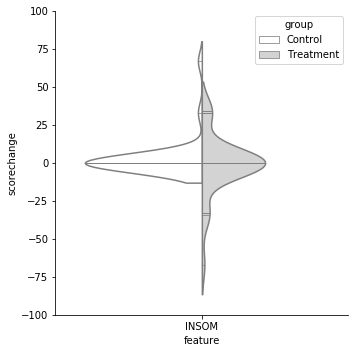

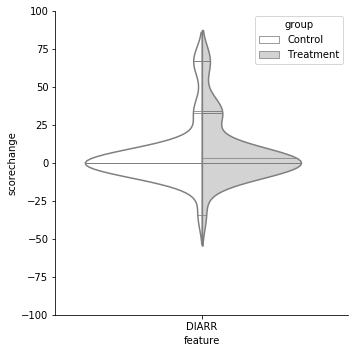

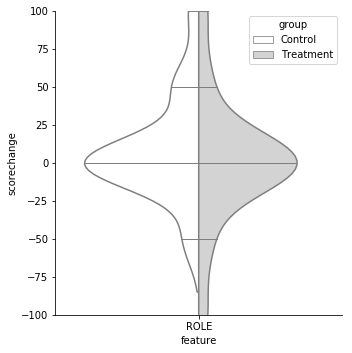

In [471]:
for value in set_val:
    print(value)
    sdf = diff_df.loc[diff_df.feature ==value]
    fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    sns.violinplot(data=sdf, y='scorechange',x='feature', hue='group', ax=ax, palette=['white', 'lightgrey'], inner='stick', split=True)

    plt.tight_layout()
    sns.despine()
    ax.set_ylim(-100, 100)
    
    plt.savefig("split_violin_{value}.png".format(value=value))
    
    

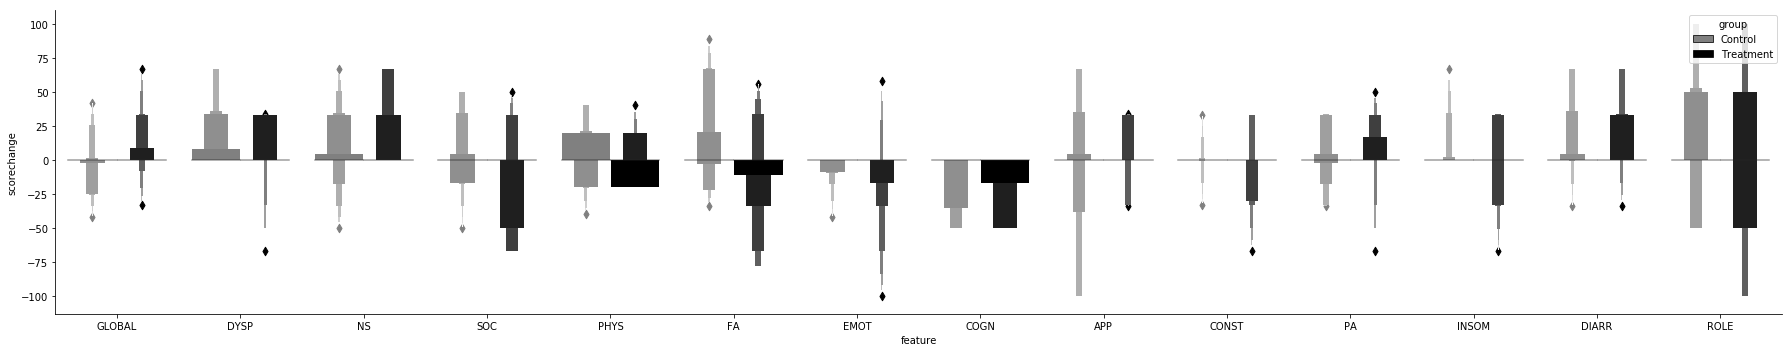

In [201]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(25,5))
sns.boxenplot(data=diff_df, y='scorechange',x='feature', hue='group', ax=ax, palette=['grey', 'black'])
plt.tight_layout()
sns.despine()
plt.show()

### make big boxplot for QOL


In [203]:
# subset data
global_diff = diff_df.loc[diff_df.feature=='GLOBAL']

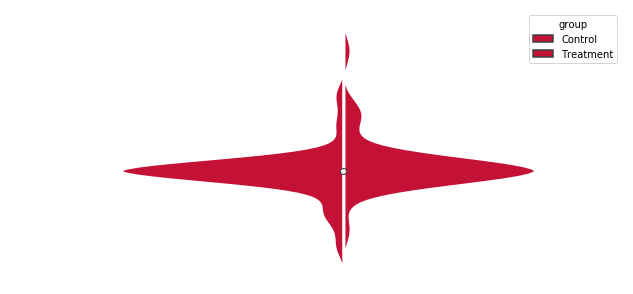

In [339]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
sns.violinplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['#C41237','#C41237'],
               saturation=1,
               split=True, linewidth=3, )
# Add transparency to colors

ax.collections[0].set_edgecolor('white')
ax.collections[1].set_edgecolor('white')


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('white')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='white',fontweight='bold')
ax.tick_params(axis='y', colors='white', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.set_yticklabels(yticks, size=15, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
#plt.show()
plt.savefig('temp.svg', transparent=True)


TypeError: boxplot() got an unexpected keyword argument 'split'

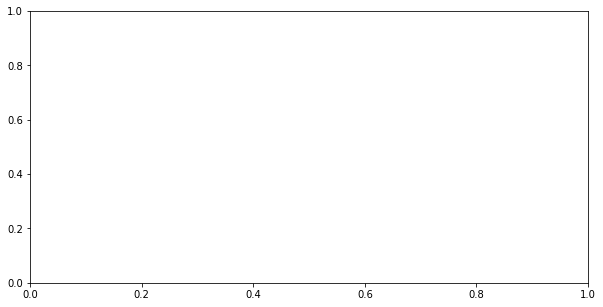

In [373]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
sns.boxplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['#C41237','#C41237'],
               saturation=1,
               split=True, linewidth=3, )
# Add transparency to colors

ax.collections[0].set_edgecolor('white')
ax.collections[1].set_edgecolor('white')


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('white')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='white',fontweight='bold')
ax.tick_params(axis='y', colors='white', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.set_yticklabels(yticks, size=15, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
#plt.show()
plt.savefig('temp.svg', transparent=True)


In [327]:
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']

In [245]:
ax.artists

[]

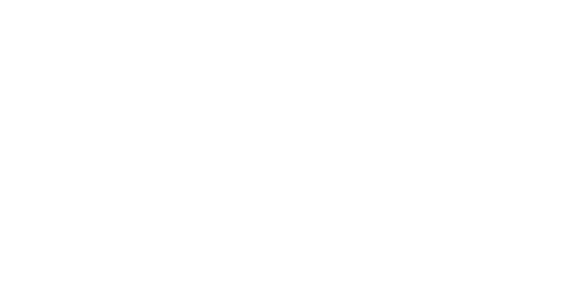

In [357]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
sns.swarmplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['White', 'White'],dodge=True)
# Add transparency to colors

ax.collections[0].set_edgecolor('white')
ax.collections[1].set_edgecolor('white')


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('white')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='white',fontweight='bold')
ax.tick_params(axis='y', colors='white', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.set_yticklabels(yticks, size=15, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)

#plt.show()
ax.spines['left'].set_position('center')
ax.get_legend().remove()
plt.savefig('temp3.png', transparent=True)


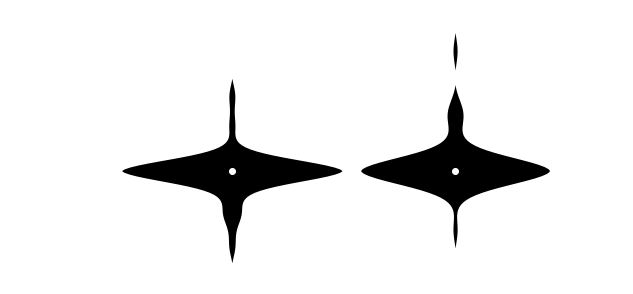

In [364]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
sns.violinplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['black', 'black'],linewidth=3, dodge=True)
# Add transparency to colors

ax.collections[0].set_edgecolor('white')
ax.collections[1].set_edgecolor('white')
ax.collections[2].set_edgecolor('white')
ax.collections[3].set_edgecolor('white')


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('white')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='white',fontweight='bold')
ax.tick_params(axis='y', colors='white', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.set_yticklabels(yticks, size=15, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)

#plt.show()
#ax.spines['left'].set_position('center')
ax.get_legend().remove()
plt.savefig('temp3.svg', transparent=True)


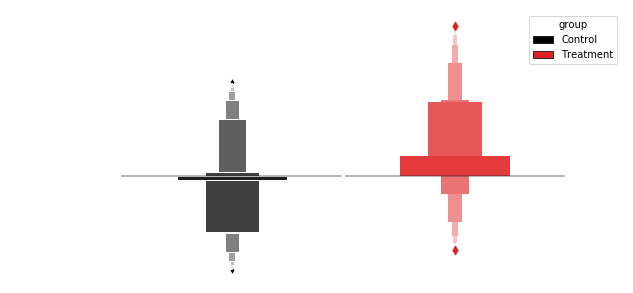

<Figure size 432x288 with 0 Axes>

In [408]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
sns.boxenplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['black', 'red'],)
# Add transparency to colors

ax.collections[0].set_edgecolor('white')
ax.collections[1].set_edgecolor('white')


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('white')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='white',fontweight='bold')
ax.tick_params(axis='y', colors='white', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-80','-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.set_yticklabels(yticks, size=15, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
plt.show()
ax.get_legend().remove()
plt.tight_layout()
#plt.savefig('temp3.png', transparent=True)
plt.show()


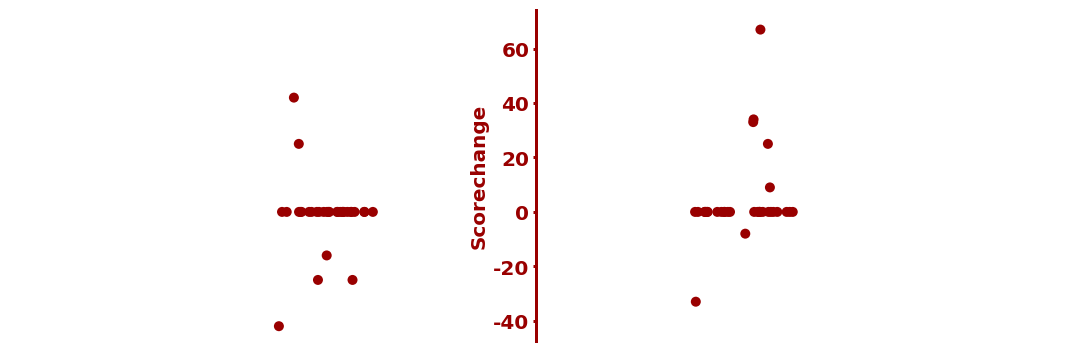

In [436]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
sns.stripplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['#990000', '#990000'],dodge=True, alpha=1, size=10)
# Add transparency to colors
ax.collections[0].set_edgecolor('#990000')
ax.collections[1].set_edgecolor('#990000')
ax.get_legend().remove()


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('#990000')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='#990000',fontweight='bold')
ax.tick_params(axis='y', colors='#990000', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.spines['left'].set_position('center')

ax.set_yticklabels(yticks, size=20, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
plt.tight_layout()
#ax.spines['left'].set_position('center')
plt.savefig('temp3_strip.png', transparent=False)
plt.show()


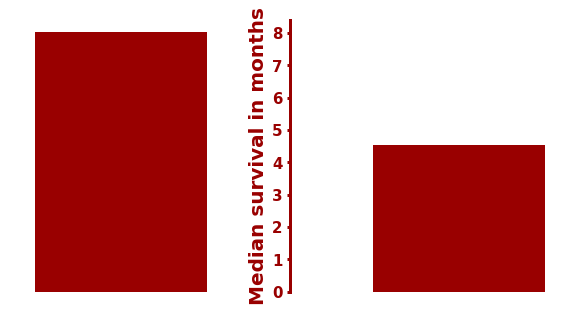

In [457]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

# Add transparency to colors

#ax.collections[0].set_edgecolor('white')
#ax.collections[1].set_edgecolor('white')
ax.bar([1,2],[8,4.5], color='#990000', edgecolor='#990000', linewidth=3, width=0.5, alpha=1)

sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('#990000')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Median survival in months', size=20, color='#990000',fontweight='bold')
ax.tick_params(axis='y', colors='#990000', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['0','1','2', '3', '4', '5', '6', '7', '8', '9']
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
ax.spines['left'].set_position('center')
ax.set_yticklabels(yticks, size=15, fontweight='bold')
#plt.show()
plt.savefig('temp_bar.png', transparent=False)




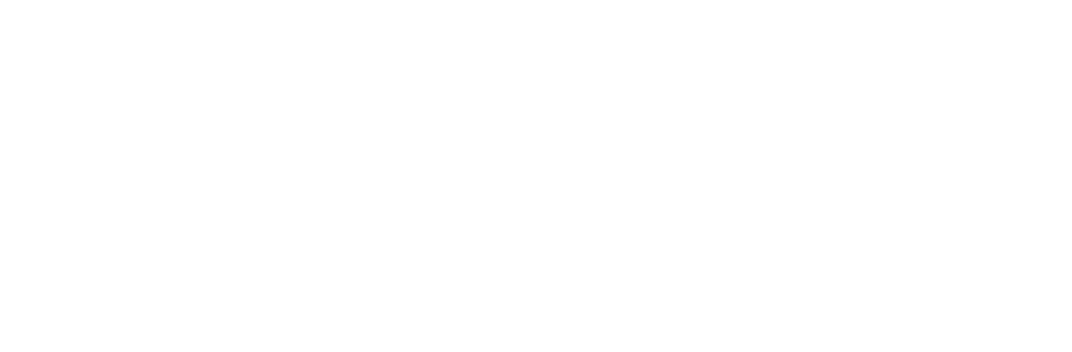

In [459]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
sns.stripplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['White', 'White'],dodge=True, alpha=1, size=10)
# Add transparency to colors
ax.collections[0].set_edgecolor('White')
ax.collections[1].set_edgecolor('White')
ax.get_legend().remove()


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('White')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='White',fontweight='bold')
ax.tick_params(axis='y', colors='White', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.spines['left'].set_position('center')

ax.set_yticklabels(yticks, size=20, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
plt.tight_layout()
#ax.spines['left'].set_position('center')
plt.savefig('temp3_strip_white.png', transparent=True)
plt.show()


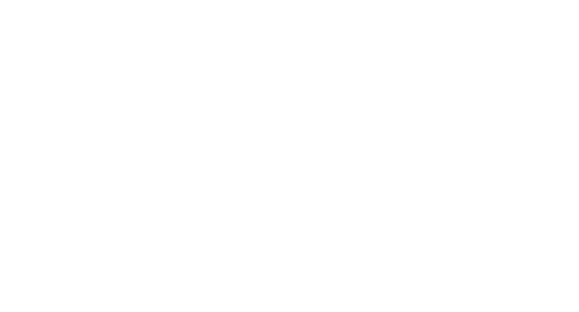

In [462]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

# Add transparency to colors

#ax.collections[0].set_edgecolor('white')
#ax.collections[1].set_edgecolor('white')
ax.bar([1,2],[8,4.5], color='White', edgecolor='White', linewidth=3, width=0.2, alpha=1)

sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('White')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Median survival in months', size=20, color='White',fontweight='bold')
ax.tick_params(axis='y', colors='White', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['0','1','2', '3', '4', '5', '6', '7', '8', '9']
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
ax.spines['left'].set_position('center')
ax.set_yticklabels(yticks, size=15, fontweight='bold')
#plt.show()
plt.savefig('temp_bar_white.png', transparent=True)


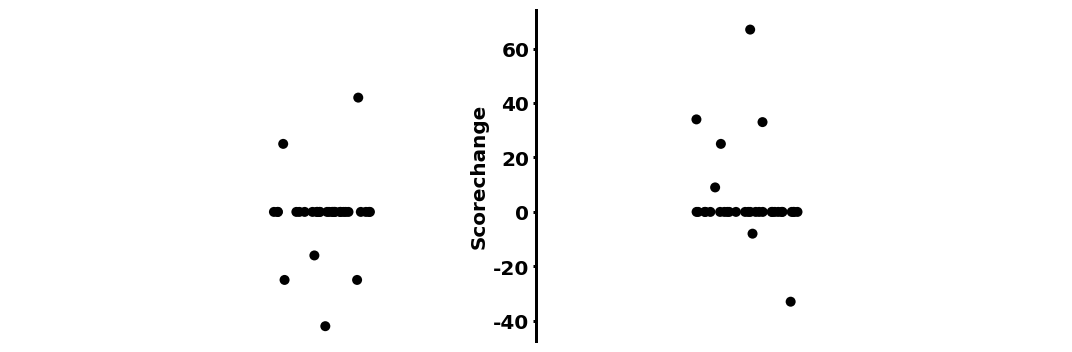

In [464]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5))
sns.stripplot(data=global_diff,
               y='scorechange',
               x='feature',
               hue='group',
               ax=ax,
               palette=['black', 'black'],dodge=True, alpha=1, size=10)
# Add transparency to colors
ax.collections[0].set_edgecolor('black')
ax.collections[1].set_edgecolor('black')
ax.get_legend().remove()


sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('black')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Scorechange', size=20, color='black',fontweight='bold')
ax.tick_params(axis='y', colors='black', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['-60','-40', '-20', '0', '20', '40', '60', '80', '100']
ax.spines['left'].set_position('center')

ax.set_yticklabels(yticks, size=20, fontweight='bold')
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
plt.tight_layout()
#ax.spines['left'].set_position('center')
plt.savefig('temp3_strip_black.png', transparent=False)
plt.show()


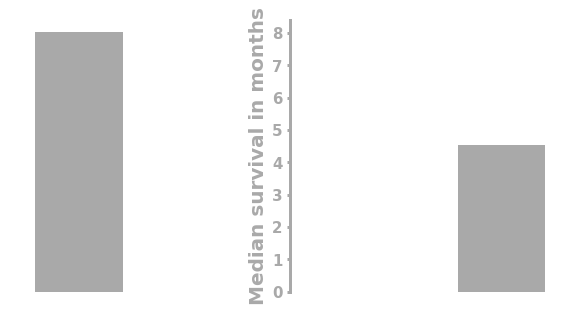

In [467]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))

# Add transparency to colors

#ax.collections[0].set_edgecolor('white')
#ax.collections[1].set_edgecolor('white')
ax.bar([1,2],[8,4.5], color='darkgrey', edgecolor='darkgrey', linewidth=3, width=0.2, alpha=1)

sns.despine(top=True, bottom=True, right=True)
ax.spines['left'].set_color('darkgrey')
#ax.yaxis.set_label( 'Scorechange', size=20)
ax.set_ylabel('Median survival in months', size=20, color='darkgrey',fontweight='bold')
ax.tick_params(axis='y', colors='darkgrey', width=3)
#yticks = list(ax.get_yticklabels())
yticks = ['0','1','2', '3', '4', '5', '6', '7', '8', '9']
ax.spines['left'].set_linewidth(3)
ax.get_xaxis().set_visible(False)
ax.spines['left'].set_position('center')
ax.set_yticklabels(yticks, size=15, fontweight='bold')
#plt.show()
plt.savefig('temp_bar_grey.png', transparent=False)
